In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import lightgbm

#### 20-21 Season

In [140]:
datapath = '../data/clean_data/windowed_data/'
window_size = '9'
season = '2020-21/'

team_name_df = pd.read_csv('../data/clean_data/master_team_list.csv')
team_name_df = team_name_df[team_name_df.season == '2020-21']
fixture_df = pd.read_csv('../data/fixtures/full_fixture_difficulty.csv')
fixture_df = fixture_df[fixture_df.season == '20_21']
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_a', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'team_h', 'team_name']]
fixture_df.rename(columns={'team_name':'away_team_name'}, inplace=True)
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_h', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'away_team_name', 'team_name']]
fixture_df.rename(columns={'team_name':'home_team_name'}, inplace=True)

def attach_difficulty(row):
    try:
        if row['was_home']:
            team = fixture_df[(fixture_df.home_team_name == row.team) & (fixture_df.away_team_name == row.opponent_team)].reset_index(drop=True).loc[0, 'team_h_difficulty']
            opponent = fixture_df[(fixture_df.home_team_name == row.team) & (fixture_df.away_team_name == row.opponent_team)].reset_index(drop=True).loc[0, 'team_a_difficulty']
            return team - opponent
        else:
            team = fixture_df[(fixture_df.home_team_name == row.opponent_team) & (fixture_df.away_team_name == row.team)].reset_index(drop=True).loc[0, 'team_a_difficulty']
            opponent = fixture_df[(fixture_df.home_team_name == row.opponent_team) & (fixture_df.away_team_name == row.team)].reset_index(drop=True).loc[0, 'team_h_difficulty']
            return team - opponent
    except KeyError:
        return 0

def read_data(pos, datapath, window_size, season, minimum_minutes=0):
    path = os.path.join(datapath, season)
    df = pd.read_csv(path + pos + window_size + '.csv')
    df = df[df.minutes >= minimum_minutes]
    df['difficulty_gap'] = df.apply(lambda r: attach_difficulty(r), axis=1, result_type='expand')
    df.drop(['team', 'opponent_team'], axis=1, inplace=True)
    
    df['total_points_bin'] = pd.qcut(df['Target_Output'], 4, labels=False)
    return df

dfs_20_21 = [read_data(p, datapath, window_size, season, minimum_minutes=1e-6) for p in ['GK_', 'DEF_', 'FWD_', 'MID_']]
full_df_20_21 = pd.concat(dfs_20_21, keys=['GK', 'DEF', 'FWD', 'MID'])

#### Combine with 21-22 season

In [141]:
season = '2021-22/'

team_name_df = pd.read_csv('../data/clean_data/master_team_list.csv')
team_name_df = team_name_df[team_name_df.season == '2021-22'].drop(columns={'team_difficulty'})
fixture_df = pd.read_csv('../data/fixtures/full_fixture_difficulty.csv')
fixture_df = fixture_df[fixture_df.season == '21_22']
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_a', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'team_h', 'team_name']]
fixture_df.rename(columns={'team_name':'away_team_name'}, inplace=True)
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_h', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'away_team_name', 'team_name']]
fixture_df.rename(columns={'team_name':'home_team_name'}, inplace=True)

dfs_21_22 = [read_data(p, datapath, window_size, season, minimum_minutes=1e-6) for p in ['GK_', 'DEF_', 'FWD_', 'MID_']]
full_df_21_22 = pd.concat(dfs_21_22, keys=['GK', 'DEF', 'FWD', 'MID'])

In [142]:
# Combine 2 seasons
dfs = [pd.concat([dfs_20_21[i], dfs_21_22[i]]) for i in range(4)]
full_df = pd.concat([full_df_20_21, full_df_21_22])

In [143]:
dfs[0].total_points_bin.value_counts()

0    585
1    506
3    393
2    169
Name: total_points_bin, dtype: int64

#### Something is inconsistent in the 2021-2022 data: there were 380 fixtures but the dataset has 380-387 different matchups

In [144]:
fixture_df[['away_team_name', 'home_team_name']].drop_duplicates()

,away_team_name,home_team_name
0,Brentford,Arsenal
1,Man Utd,Leeds
2,Burnley,Brighton
3,Chelsea,Crystal Palace
4,Everton,Southampton
...,...,...
375,Crystal Palace,Man Utd
376,Leicester,Southampton
377,Liverpool,Wolves
378,Man City,Aston Villa


In [145]:
season = '2021-22/'
a = pd.read_csv(os.path.join(datapath, season) + 'MID_' + window_size + '.csv')
a[['team', 'opponent_team']].drop_duplicates()

,team,opponent_team
0,Spurs,Man Utd
1,Spurs,Fulham
2,Spurs,Leeds
3,Spurs,Brighton
4,Spurs,Sheffield Utd
...,...,...
2877,Liverpool,Leeds
2881,Liverpool,West Brom
2882,Liverpool,Man City
2883,Liverpool,Man Utd


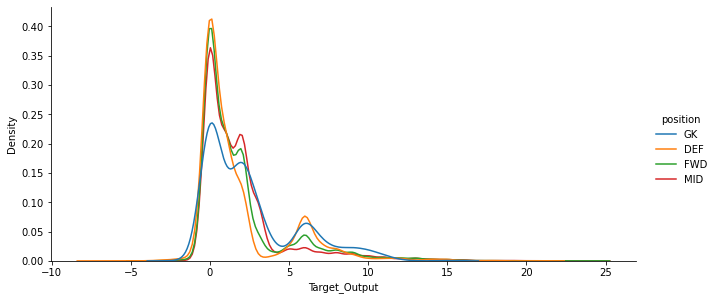

In [146]:
plot = sns.displot(
    data=full_df.reset_index().rename(columns={'level_0': 'position'}), 
    x="Target_Output",
    hue='position',
    kind='kde',
    common_norm=False,
    height=4.27, aspect=17.7/8.27)
#plot.fig.suptitle("Score Distribution by Position",
#                  fontsize=15, fontdict={"weight": "bold"})
plot.figure.savefig('eda_pos_dist.png',dpi=600)

### Note: qcut reduces spread of mse a bit more compared to cut

In [147]:
dfs[0].total_points_bin.value_counts()

0    585
1    506
3    393
2    169
Name: total_points_bin, dtype: int64

In [148]:
dfs[0].columns

Index(['assists', 'clean_sheets', 'creativity', 'bps', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'threat',
       'yellow_cards', 'total_points', 'was_home', 'Target_Output',
       'difficulty_gap', 'total_points_bin'],
      dtype='object')

<AxesSubplot:>

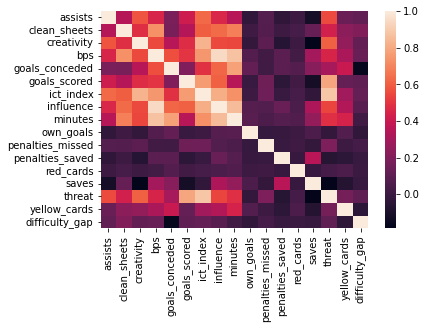

In [149]:
corr = dfs[2].drop(columns={'Target_Output', 'total_points', 'total_points_bin'}).select_dtypes('number').corr()
sns.heatmap(corr)

### Modeling

In [150]:
# For lightgbm
param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'n_estimators': [50, 100, 200],
    'num_leaves': [7, 15, 31],
    'reg_alpha': [0.01, 10],
    'reg_lambda': [10, 100],
    'min_data_in_leaf': [70, 210],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.1, 0.01],
    'verbose': [-1]
}

In [151]:
def get_results(data):
    results = {}
    print('Starting...')
    
    data = pd.get_dummies(data)
    X = data.drop('Target_Output', axis=1)
    y = data.Target_Output

    # Test set is still held-out and won't be used until writing the report.
    # Stratified split (by binned minutes)
    split_criteria_name = 'total_points_bin'
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=1, 
        stratify=X[split_criteria_name]
    )
    split_criteria = X_train[split_criteria_name]
    X_train.drop(split_criteria_name, axis=1, inplace=True)
    X_test.drop(split_criteria_name, axis=1, inplace=True)
    
    #splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    splitter = StratifiedKFold(n_splits=5)
    
    # Grid Search for lightgbm
    # Stratified cv (by binned minutes)
    grid = GridSearchCV(
        lightgbm.LGBMRegressor(random_state=0), 
        param_grid, 
        scoring='neg_mean_squared_error',
        cv=splitter.split(X_train, split_criteria),
        return_train_score=True,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_in_grid = grid.best_estimator_
    results['lgbm_est'] = best_in_grid
    results['lgbm_full_stats'] = grid.cv_results_
    
    results['lgbm_report'] = [-grid.cv_results_['mean_train_score'][grid.cv_results_['mean_test_score'].argmax()],
        grid.cv_results_['std_train_score'][grid.cv_results_['mean_test_score'].argmax()],
        -grid.cv_results_['mean_test_score'].max(),
        grid.cv_results_['std_test_score'][grid.cv_results_['mean_test_score'].argmax()], 
                              mean_squared_error(y_test, best_in_grid.predict(X_test))]
    results['lgbm_test_set'] = [X_test, y_test, best_in_grid.predict(X_test)]
    
    # Linear Model
    lrgrid = GridSearchCV(
        linear_model.Ridge(), 
        {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
        scoring='neg_mean_squared_error',
        cv=splitter.split(X_train, split_criteria),
        return_train_score=True,
        verbose=1
    )
    lrgrid.fit(X_train, y_train)
    print(lrgrid.best_params_)
    best_in_grid = lrgrid.best_estimator_
    results['lr_coef'] = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(best_in_grid.coef_))], axis = 1)
    results['lr_full_stats'] = lrgrid.cv_results_
    
    results['lr_report'] = [
        -lrgrid.cv_results_['mean_train_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        lrgrid.cv_results_['std_train_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        -lrgrid.cv_results_['mean_test_score'].max(),
        lrgrid.cv_results_['std_test_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        mean_squared_error(y_test, best_in_grid.predict(X_test))
    ]
    results['lr_test_set'] = [y_test, best_in_grid.predict(X_test)]
    
    results['heuristic'] = mean_squared_error(y_test, X_test.total_points)
    
    return results

In [152]:
def_results = get_results(dfs[1])

Starting...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}


In [153]:
gk_results = get_results(dfs[0])

Starting...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}


In [154]:
fwd_results = get_results(dfs[2])

Starting...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}


In [155]:
mid_results = get_results(dfs[3])

Starting...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}


In [156]:
report_table = {'GK': gk_results['lgbm_report'] + gk_results['lr_report'],
                'DEF': def_results['lgbm_report'] + def_results['lr_report'], 
                'MID': mid_results['lgbm_report'] + mid_results['lr_report'], 
                'FWD': fwd_results['lgbm_report'] + fwd_results['lr_report']}
col_map = {0:'lgbm_train_avg_mse', 1:'lgbm_train_mse_std', 2: 'lgbm_valid_avg_mse', 3: 'lgbm_valid_mse_std',
          4: 'lgbm_TEST_mse', 5: 'lr_train_avg_mse', 6: 'lr_train_mse_std', 7: 'lr_valid_avg_mse', 8: 'lr_valid_mse_std',
          9: 'lr_TEST_mse'}
report_table = pd.DataFrame.from_dict(report_table, orient='index').rename(columns=col_map)

In [157]:
report_table.iloc[:, :5]

,lgbm_train_avg_mse,lgbm_train_mse_std,lgbm_valid_avg_mse,lgbm_valid_mse_std,lgbm_TEST_mse
GK,5.773797,0.195929,6.694305,0.835287,5.911575
DEF,6.563588,0.096380,7.186818,0.407315,7.052221
MID,5.874967,0.098781,6.167916,0.381202,6.136429
FWD,6.596459,0.082318,6.827554,0.342499,7.030317


In [158]:
report_table.iloc[:, 5:]

,lr_train_avg_mse,lr_train_mse_std,lr_valid_avg_mse,lr_valid_mse_std,lr_TEST_mse
GK,6.711856,0.213604,6.796007,0.862049,6.019652
DEF,7.154299,0.104274,7.191976,0.412990,7.039315
MID,6.133609,0.096876,6.157385,0.387985,6.015206
FWD,6.799473,0.085493,6.824589,0.341612,7.040270


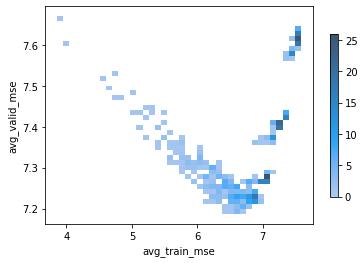

In [163]:
def lgbm_overfit_plot(res):
    overfit = {
        'avg_train_mse': -res['lgbm_full_stats']['mean_train_score'],
        'avg_valid_mse': -res['lgbm_full_stats']['mean_test_score']
    }
    overfit = pd.DataFrame.from_dict(overfit)

    plot = sns.histplot(
        overfit, x='avg_train_mse', y='avg_valid_mse',
        bins=40, cbar=True, cbar_kws=dict(shrink=.75),
    )
    #.set_title('Hyperparameter Tuning to Prevent Overfit\nGradient Boosting - Midfielders')
    return plot

plot = lgbm_overfit_plot(def_results)
plot.figure.savefig('overfit_lgbm.png',dpi=600)

#### \!\!\! No longer a good visualization

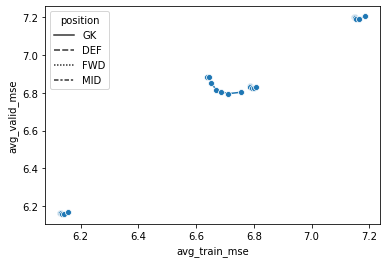

In [164]:
def lr_overfit_plot(res_lst, name_lst):
    overfit = pd.DataFrame()
    for i, res in enumerate(res_lst):
        temp = {
            'avg_train_mse': -res['lr_full_stats']['mean_train_score'],
            'avg_valid_mse': -res['lr_full_stats']['mean_test_score']
        }
        temp = pd.DataFrame.from_dict(temp)
        #temp['normalized_avg_train_mse'] = MinMaxScaler().fit_transform(np.array(temp['avg_train_mse']).reshape(-1,1))
        #temp['normalized_avg_valid_mse'] = MinMaxScaler().fit_transform(np.array(temp['avg_valid_mse']).reshape(-1,1))
        temp['position'] = name_lst[i]
        overfit = pd.concat([overfit, temp], ignore_index=True)
    
    plot = sns.lineplot(
        data=overfit, x='avg_train_mse', y='avg_valid_mse', style='position',
        marker='o', palette="flare"
    )
    #.set_title('Hyperparameter Tuning to Prevent Overfit\n Ridge Regression - All Positions')
    return plot
    

plot = lr_overfit_plot([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])
plot.figure.savefig('output_figure.png',dpi=600)

#### Stratified Splits are working as intended

In [165]:
def check_distribution(res_lst):
    for i, res in enumerate(res_lst):
        test_y = res['lgbm_test_set'][1]
        print('Based on average score')
        print('test std:', test_y.std(), 'full std:', dfs[i].Target_Output.std())
        print('test mean:', test_y.mean(), 'full mean:', dfs[i].Target_Output.mean())

check_distribution([gk_results, def_results, fwd_results, mid_results])

Based on average score
test std: 2.7894958670274694 full std: 2.8867907975959826
test mean: 2.4471299093655587 full mean: 2.488808227465215
Based on average score
test std: 2.8243872226258713 full std: 2.8431751306194806
test mean: 1.8117106773823193 full mean: 1.8035837353549276
Based on average score
test std: 2.8498975942233638 full std: 2.8329078660845486
test mean: 1.8956336528221511 full mean: 1.8773698785770077
Based on average score
test std: 2.6267911124655594 full std: 2.7166155854003753
test mean: 1.8486932599724897 full mean: 1.8717102246675836


In [118]:
gk_test_x = def_results['lgbm_test_set'][0]
#gk_test_x['y_true'] = gk_results['lgbm_test_set'][1]
#gk_test_x['y_pred'] = gk_results['lgbm_test_set'][2]
#gk_test_x['error'] = np.abs(gk_test_x['y_pred'] - gk_test_x['y_true'])

In [110]:
gk_test_x.sort_values(by='error').head(3)

,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,...,red_cards,saves,threat,yellow_cards,total_points,was_home,difficulty_gap,y_true,y_pred,error
2019,0.0,0.3,0.0,13.8,1.5,0.0,1.10,10.96,81.0,0.0,...,0.0,1.4,0.0,0.0,2.9,False,0,3.0,3.007213,0.007213
1441,0.0,0.5,0.0,22.2,0.9,0.0,2.62,26.32,90.0,0.0,...,0.0,3.7,0.0,0.0,6.0,True,0,4.0,4.019689,0.019689
1617,0.0,0.1,0.0,13.7,1.1,0.0,2.10,20.98,72.0,0.0,...,0.0,2.7,0.0,0.1,2.3,True,0,3.0,3.045024,0.045024


In [111]:
gk_test_x.sort_values(by='error').tail(3)

,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,...,red_cards,saves,threat,yellow_cards,total_points,was_home,difficulty_gap,y_true,y_pred,error
1422,0.0,0.444444,0.0,21.0,1.444444,0.0,2.311111,23.177778,90.0,0.0,...,0.0,2.555556,0.0,0.0,4.666667,False,1,11.0,3.235905,7.764095
717,0.0,0.800000,0.0,19.1,0.100000,0.0,1.130000,11.300000,81.0,0.0,...,0.0,1.400000,0.0,0.2,5.000000,True,0,12.0,3.847299,8.152701
1424,0.0,0.000000,0.0,2.9,0.500000,0.0,0.380000,3.800000,18.0,0.0,...,0.0,0.500000,0.0,0.0,0.300000,False,0,11.0,0.704162,10.295838


In [97]:
mid_results['lgbm_est'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'num_leaves': 7,
 'objective': 'regression',
 'random_state': 1,
 'reg_alpha': 0.01,
 'reg_lambda': 100,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'min_data_in_leaf': 70,
 'verbose': -1}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

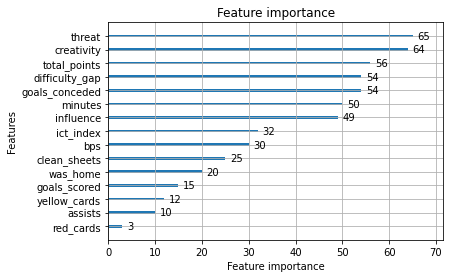

In [100]:
lightgbm.plot_importance(def_results['lgbm_est'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

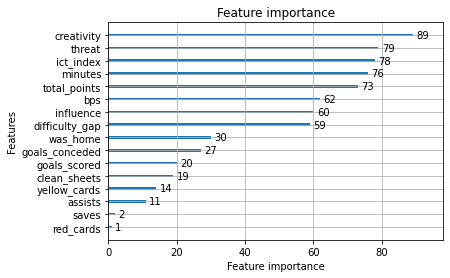

In [101]:
lightgbm.plot_importance(fwd_results['lgbm_est'])

In [105]:
mid_results['lr_coef']

,0,0
0,assists,-0.200526
1,clean_sheets,-0.034391
2,creativity,0.041929
3,bps,-0.073641
4,goals_conceded,-0.162710
5,goals_scored,0.125022
6,ict_index,-0.015786
7,influence,0.033232
8,minutes,0.014460
9,own_goals,0.000643
